In [1]:
import numpy as np
import unyt
import swiftsimio as sw
from swiftsimio import load
import swiftgalaxy as sg

def radial_distance(x, y,z):
    return np.sqrt(x**2 + y**2+z**2)

def spherical_harmonic_0(x, y,z):
    r = radial_distance(x, y,z)
    return np.sqrt(5/16/np.pi)*(3*z**2-r**2)/r**2
def spherical_harmonic_1(x, y,z):
    r = radial_distance(x, y,z)  
    return np.sqrt(15/4/np.pi)*x*z/r**2
def spherical_harmonic_2(x, y,z): 
    r = radial_distance(x, y,z)
    return np.sqrt(15/16/np.pi)*(x**2-y**2)/r**2
def spherical_harmonic__1(x, y,z):
    r = radial_distance(x, y,z)
    return np.sqrt(15/4/np.pi)*y*z/r**2 
def spherical_harmonic__2(x, y,z):
    r = radial_distance(x, y,z)
    return np.sqrt(15/4/np.pi)*x*y/r**2 
def quadrupole(x, y,z,num_particles):
    r = radial_distance(x, y,z)
    f0=np.sum(spherical_harmonic_0(x, y,z)*r)
    f1=np.sum(spherical_harmonic_1(x, y,z)*r)
    f2=np.sum(spherical_harmonic_2(x, y,z)*r)
    f_1=np.sum(spherical_harmonic__1(x, y,z)*r)
    f_2=np.sum(spherical_harmonic__2(x, y,z)*r)
    return np.sqrt(f0**2+f1**2+f2**2+f_1**2+f_2**2) / num_particles
   
def dissociation(x_dm, y_dm,z_dm ,x_g, y_g, z_g):
    n_dm = len(x_dm)
    n_g = len(x_g)
    r_mean_dm = np.average(radial_distance(x_dm, y_dm,z_dm))
    r_mean_g = np.average(radial_distance(x_g, y_g,z_g))
    r_max = max(r_mean_dm, r_mean_g)
    q_dm = quadrupole(x_dm, y_dm,z_dm, n_dm)
    q_g = quadrupole(x_g, y_g, z_g,n_g)
    return np.sqrt(4*np.pi/5) * (q_dm - q_g) / r_max


#work with SOAP
#load the data
soap_dir="../../../mnt/su3-pro/colibre/L0012N0094/THERMAL_AGN/SOAP/"

data_h=sw.load(soap_dir+"/halo_properties_0127.hdf5")




#select the main halo
host_id=data_h.soap.host_halo_index#central halo=-1\
halo_id=np.arange(0,len(host_id),1)
mass=data_h.spherical_overdensity_200_crit.total_mass
mainhalo_id=halo_id[(host_id==-1)*(mass>10)]
data_h=[]

x_dm=[[]]
y_dm=[[]]
z_dm=[[]]
x_g=[[]]
y_g=[[]]
z_g=[[]]
for i in range(0, len(mainhalo_id)-1):
  
    x_dm.append([])
    x_g.append([])
    z_dm.append([])
    y_dm.append([])
    y_g.append([])
    z_g.append([])

/home/jyang/anaconda3/envs/mypython/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=0.9999999999999997) for all arguments.
  warnings.warn(
/home/jyang/anaconda3/envs/mypython/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


In [15]:
sga=sg.SWIFTGalaxies(soap_dir+"colibre_with_SOAP_membership_0127.hdf5",
    sg.SOAP(soap_dir+"/halo_properties_0127.hdf5",soap_index=mainhalo_id),
    preload={"dark_matter.cartesian_coordinates","gas.cartesian_coordinates"})


In [16]:
i=0
def analyse(sgi,i):
      x_dm[i]=np.array(sgi.dark_matter.cartesian_coordinates.x)
      y_dm[i]=np.array(sgi.dark_matter.cartesian_coordinates.y)
      z_dm[i]=np.array(sgi.dark_matter.cartesian_coordinates
      .z)
      x_g[i]=np.array(sgi.gas.cartesian_coordinates.x)
      y_g[i]=np.array(sgi.gas.cartesian_coordinates.y)
      z_g[i]=np.array(sgi.gas.cartesian_coordinates.z)

In [17]:
for sgi in sga:
    analyse(sgi,i)
    i+=1    

In [7]:
S=[]
for i in  range(0,len(x_dm)):
      x_dmc=np.sum(x_dm[i])/len(x_dm[i])
      x_gc=np.sum(x_g[i])/len(x_g[i])
      x_dm[i]-=x_dmc
      x_g[i]-=x_gc
      y_dmc=np.sum(y_dm[i])/len(y_dm[i])
      y_dm[i]-=y_dmc
      y_gc=np.sum(y_g[i])/len(y_g[i])
      y_g[i]-=y_gc
      z_dmc=np.sum(z_dm[i])/len(z_dm[i])
      z_dm[i]-=z_dmc
      z_gc=np.sum(z_g[i])/len(z_g[i]) 
      z_g[i]-=z_gc
      S.append(dissociation(x_dm[i], y_dm[i], z_dm[i],x_g[i], y_g[i],z_g[i]))

In [9]:
print(np.array(S))

[ 0.07665969  0.05377132  0.01970191  0.22320383 -0.0813214  -0.07920694
 -0.09078546 -0.03243601  0.01770792 -0.04698301  0.10242683 -0.02090254
  0.00512745 -0.00242519 -0.09889941  0.01825866  0.06611868  0.01324776
  0.2500724  -0.05291342 -0.000437    0.14047361  0.19332696 -0.08932368
  0.04743861  0.10022478]


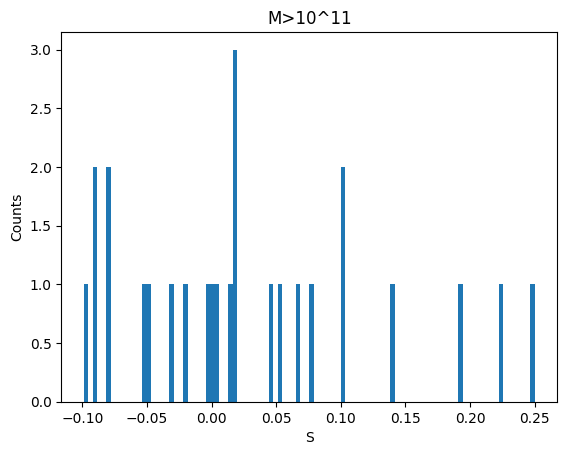

In [10]:
import matplotlib.pyplot as plt
plt.close()
fig = plt.figure()
ax=plt.subplot(1,1,1)
h=ax.hist(S, bins=100)
ax.set_xlabel("S")
ax.set_ylabel("Counts")
ax.set_title("M>10^11")
fig.savefig("./S.png")

In [21]:
Offset=[]
for i in  range(0,len(x_dm)):
      x_dmc=np.sum(x_dm[i])/len(x_dm[i])
      x_gc=np.sum(x_g[i])/len(x_g[i])
      y_dmc=np.sum(y_dm[i])/len(y_dm[i]) 
      y_gc=np.sum(y_g[i])/len(y_g[i])
      z_dmc=np.sum(z_dm[i])/len(z_dm[i])
      z_gc=np.sum(z_g[i])/len(z_g[i]) 
      Offset.append(radial_distance(x_dmc-x_gc, y_dmc-y_gc, z_dmc-z_gc))
print(np.array(Offset)*1000)

[67.3193834   5.1492169   9.00515149 14.10555223 26.7872291   9.24594494
 10.87225872  4.17580657  1.87050596  3.3536526   1.470555   51.20067791
 10.18070814  4.12850707 10.6029429   3.41681775  3.44705633  9.1624006
 12.06020749  8.87844501  9.98865965 15.0445685   7.61822418  2.93758589
 18.23115434 53.71565694]
